In [1]:
import gdal
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import torch
from glob import glob
import shapely
import random
from tqdm import tqdm
from collections import Counter
from pybob.GeoImg import GeoImg
import osr
from pybob.image_tools import create_mask_from_shapefile
import gc
import imageio
import time
import shutil

In [2]:
def get_mask(maskshp,geotrf,shape,p='4326'):
    img=np.zeros((shape[0],shape[1]))
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    
    trf=(geotrf[0], geotrf[1], geotrf[2], geotrf[3], geotrf[4], geotrf[5])
    drv = gdal.GetDriverByName('MEM')
    dst = drv.Create('', shape[1], shape[0], 1, gdal.GDT_UInt16)

    sp = dst.SetProjection(proj)
    sg = dst.SetGeoTransform(trf)

    wa = dst.GetRasterBand(1).WriteArray(img)
    del wa, sg, sp
    img_bob = GeoImg(dst)
    mask = create_mask_from_shapefile(img_bob, maskshp)
    return mask
def read_img(path):
    ds=gdal.Open(path)
    trf=ds.GetGeoTransform()
    img=ds.ReadAsArray()
    return {'trf':trf,'img':img}
def tif_save_bands(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[2],img.shape[1],img.shape[0],6,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    for i in range(img.shape[0]):
        new_img.GetRasterBand(i+1).WriteArray(img[i,:,:])
    new_img.FlushCache()
    del new_img
def tif_save(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[1],img.shape[0],1,6,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    new_img.GetRasterBand(1).SetNoDataValue(0)
    new_img.GetRasterBand(1).WriteArray(img)
    new_img.FlushCache()
    del new_img

# 图像预处理

In [3]:
shp_root='/home/hk/python_script/Ukraine/data/UNOSAT/Syria/'
img_root='/data2/Syria_img/'
k=['A','B','C','D','E']
name=[os.path.basename(i).split('_')[0] for i in glob(shp_root+'*settlements.shp')]#城市名
points_pathes={}#损毁点路径dict
img_pathes={}#图像路径dict
no_shp_pathes={}#未分析区域shp文件
settlements_pathes={}
cloud_shp_pathes=glob(shp_root+'*cloud.shp')

for n in name:
    n_p={}
    for k_ in k:
        p=glob(shp_root+f'{n}_{k_}_2*.shp')
        if len(p)!=0:
            n_p[k_]=p[0]
    points_pathes[n]=n_p
for n in name:
    n_p={}
    for k_ in k:
        p=glob(img_root+f'{n}_{k_}*treated.tif')
        if len(p)!=0:
            n_p[k_]=p[0]
    img_pathes[n]=n_p
for n in name:
    no_shp_pathes[n]=shp_root+n+'_NoAnalysis.shp'
for n in name:
    settlements_pathes[n]=shp_root+n+'_settlements.shp'


In [4]:
cities=name

In [5]:
cities=['Homs']

In [24]:
city='Deir-ez-Zor'

In [13]:
for city in cities:
    print(city)
    img_root='/data2/Syria_img/'
    for i in [i for i in glob(img_root+f'{city}_A*.tif') if 'treated' not in i]:
        # print(i)
        ds=gdal.Open(i)
        # print(ds.GetGeoTransform())
        print(ds.RasterXSize,ds.RasterYSize)
        # print()
    for i in img_pathes[city].keys():
        ds=gdal.Open(img_pathes[city][i])
        # print(ds.GetGeoTransform())
        print(ds.RasterXSize,ds.RasterYSize)
    img_root='/data2/Syria_img/'
    for i in [i for i in glob(img_root+f'{city}_A*.tif') if 'treated' not in i]:
        # print(i)
        ds=gdal.Open(i)
        print(ds.GetGeoTransform())
        # print(ds.RasterXSize,ds.RasterYSize)
        # print()
    for i in img_pathes[city].keys():
        # print(img_pathes[city][i])
        ds=gdal.Open(img_pathes[city][i])
        print(ds.GetGeoTransform())
        # print(ds.RasterXSize,ds.RasterYSize)

Homs
18176 15616
18176 15616
18176 15616
18176 15616
18176 15616
18176 15616
18176 15616
(36.665496826171875, 5.364418029785156e-06, 0.0, 34.7662353515625, 0.0, -5.364418029785156e-06)
(36.665496826171875, 5.364418029785156e-06, 0.0, 34.7662353515625, 0.0, -5.364418029785156e-06)
(36.665496826171875, 5.364418029785156e-06, 0.0, 34.7662353515625, 0.0, -5.364418029785156e-06)
(36.665496826171875, 5.364418029785156e-06, 0.0, 34.7662353515625, 0.0, -5.364418029785156e-06)
(36.665496826171875, 5.364418029785156e-06, 0.0, 34.7662353515625, 0.0, -5.364418029785156e-06)
(36.665496826171875, 5.364418029785156e-06, 0.0, 34.7662353515625, 0.0, -5.364418029785156e-06)
(36.665496826171875, 5.364418029785156e-06, 0.0, 34.7662353515625, 0.0, -5.364418029785156e-06)


In [14]:
# fs=glob(img_root+f'{city}*enhance*.tif')
# trf=(37.033538818359375, 5.364418029785156e-06, 0.0, 36.29608154296875, 0.0, -5.364418029785156e-06)
# for f in fs:
#     print(f)
#     img=read_img(f)
#     print('complete load')
#     img['img']=img['img'][:,:,256:]
#     print(img['img'].shape)
#     tif_save_bands(img['img'],f,trf,p='4326')

In [15]:
settlements_pathes

{'Homs': '/home/hk/python_script/Ukraine/data/UNOSAT/Syria/Homs_settlements.shp',
 'Idlib': '/home/hk/python_script/Ukraine/data/UNOSAT/Syria/Idlib_settlements.shp',
 'Raqqa': '/home/hk/python_script/Ukraine/data/UNOSAT/Syria/Raqqa_settlements.shp',
 'Aleppo': '/home/hk/python_script/Ukraine/data/UNOSAT/Syria/Aleppo_settlements.shp',
 'Deir-ez-Zor': '/home/hk/python_script/Ukraine/data/UNOSAT/Syria/Deir-ez-Zor_settlements.shp',
 'Hama': '/home/hk/python_script/Ukraine/data/UNOSAT/Syria/Hama_settlements.shp'}

In [17]:
img_pathes=[i for i in glob(img_root+f'{city}_A-*.tif') if 'treated' not in i]
img_pathes

['/data2/Syria_img/Homs_A-2_201006015.tif.tif',
 '/data2/Syria_img/Homs_A-3_20090911.tif.tif',
 '/data2/Syria_img/Homs_A-4_20090319.tif.tif']

Warning 1: Failed to fetch spatial reference on layer Homs_settlements to build transformer, assuming matching coordinate systems.


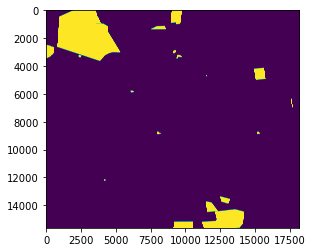

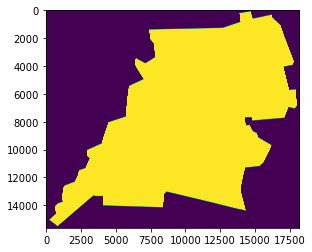

/data2/Syria_img/Homs_A-2_201006015.tif.tif
255
show


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


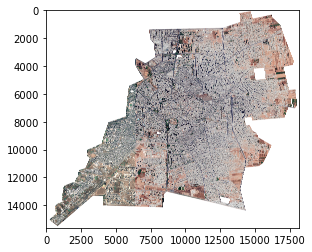

/data2/Syria_img/Homs_A-3_20090911.tif.tif
255
show


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


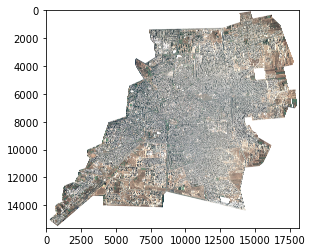

/data2/Syria_img/Homs_A-4_20090319.tif.tif
255
show


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


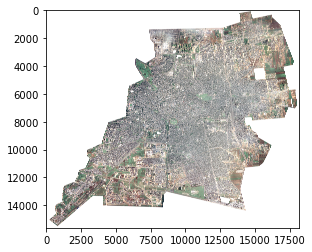

In [19]:
#切割边界，去除军事区
city='Homs'
# for city in cities:
# img_pathes=glob(img_root+f'{city}*enhance*.tif')
# img_pathes=['/data2/Syria_img/Raqqa_enhance-A-B-4_20130213.tif']
ds=gdal.Open(img_pathes[0])
w,h=ds.RasterXSize,ds.RasterYSize
noanalysis_mask=get_mask(f'/home/hk/python_script/Ukraine/data/UNOSAT/Syria/{city}_NoAnalysis.shp',ds.GetGeoTransform(),[h,w])
settlements_mask=get_mask(f'/home/hk/python_script/Ukraine/data/UNOSAT/Syria/{city}_settlements.shp',ds.GetGeoTransform(),[h,w])
fig=plt.figure()
plt.imshow(noanalysis_mask)
plt.show()
del fig
gc.collect()
fig=plt.figure()
plt.imshow(settlements_mask)
plt.show()
del fig
gc.collect()
for img_path in img_pathes:
    # try:  
    print(img_path)
    save_path=img_path.replace('.tif','_treated.tif')
    if os.path.exists(save_path):
        continue
    
    img=read_img(img_path)
    trf=img['trf']
    img=img['img'].transpose(1,2,0)
    img=img.astype(np.int)
    print(img.max())
    for i in range(3):
        img[:,:,i][settlements_mask==0]=999
        img[:,:,i][noanalysis_mask==1]=999
    print('show')
    plt.imshow(img)
    plt.show()

    # fig=plt.figure()
    # plt.imshow(img[:,:30000,:])
    # plt.show()

    # fig=plt.figure()
    # plt.imshow(img[:,30000:,:])
    # plt.show()
    # del fig
    # gc.collect()
    
    img=img.transpose(2,0,1)
    tif_save_bands(img,save_path,trf,p='4326')
    del img
    gc.collect()
    # except:
    #     print('ERROR',img_path)


In [20]:
img_pathes=glob(img_root+f'{city}_A-*_treated.tif')
img_pathes

['/data2/Syria_img/Homs_A-3_20090911_treated.tif',
 '/data2/Syria_img/Homs_A-2_201006015_treated.tif',
 '/data2/Syria_img/Homs_A-4_20090319_treated.tif']

# 转换图像为Patch

In [21]:
city='Homs'

In [22]:
def read_img(path):
    ds=gdal.Open(path)
    trf=ds.GetGeoTransform()
    img=ds.ReadAsArray()
    return {'trf':trf,'img':img}
def get_patch(data,size):
    img=data['img']
    trf=data['trf']
    shape=img.shape
    img=np.pad(img,((0,0),(0,size-shape[1]%size),(0,size-shape[2]%size)),'constant',constant_values=0)
    shape=img.shape
    img=img.reshape([shape[0],int(shape[1]/size),-1,shape[2]])
    shape=img.shape
    img=img.reshape([shape[0],shape[1],shape[2],int(shape[3]/size),-1])
    return {'img':img.transpose((0,1,3,2,4)),'trf':(trf[0]-trf[1]/2,trf[1]*size,trf[2],trf[3]-trf[5]/2,trf[4],trf[5]*size)}
for city in cities:
    size=120
    img_pathes=glob(img_root+f'{city}_A-*_treated.tif')
    # img_pathes=['/data2/Syria_img/Raqqa_enhance-A-B-4_20130213_treated.tif']
    print(img_pathes)
    for path in img_pathes:
        try:    

            print(path)
            data=read_img(path)
            print(data['img'].shape)
            data2=get_patch(data,size)
            print(data2['img'].shape)
            print(data2['trf'])
            d=data2['img'].astype(np.int16)
            info={'readme':'trf分别为patch左上角坐标(不是左上角像元的中心坐标)和patch的长度','trf':data2['trf'],'shape':[data['img'].shape,d.shape]}

            np.save(path.replace('.tif',f'_size_{size}.npy'),d)
            print('max:',d.max())
            torch.save(info,path.replace('.tif',f'_size_{size}_info.pth'))
            del data,data2,d
            gc.collect()
        except:
                print('ERROR',path)

['/data2/Syria_img/Homs_A-3_20090911_treated.tif', '/data2/Syria_img/Homs_A-2_20100615_treated.tif', '/data2/Syria_img/Homs_A-4_20090319_treated.tif']
/data2/Syria_img/Homs_A-3_20090911_treated.tif
(3, 15616, 18176)
(3, 131, 152, 120, 120)
(36.66549414396286, 0.0006437301635742188, 0.0, 34.766238033771515, 0.0, -0.0006437301635742188)
max: 999
/data2/Syria_img/Homs_A-2_20100615_treated.tif
(3, 15616, 18176)
(3, 131, 152, 120, 120)
(36.66549414396286, 0.0006437301635742188, 0.0, 34.766238033771515, 0.0, -0.0006437301635742188)
max: 999
/data2/Syria_img/Homs_A-4_20090319_treated.tif
(3, 15616, 18176)
(3, 131, 152, 120, 120)
(36.66549414396286, 0.0006437301635742188, 0.0, 34.766238033771515, 0.0, -0.0006437301635742188)
max: 999


# 制作样本

In [24]:
img_pathes=glob(img_root+f'{city}_A-*_treated_*.npy')
img_pathes.sort()
img_pathes

['/data2/Syria_img/Homs_A-2_20100615_treated_size_120.npy',
 '/data2/Syria_img/Homs_A-3_20090911_treated_size_120.npy',
 '/data2/Syria_img/Homs_A-4_20090319_treated_size_120.npy']

In [32]:
# masks={
#     'A':None,
#     'B':glob(f'/data2/Syria_img/{city}_B_*_treated_size_120_dammask.pth.tar')[0],
#     'C':glob(f'/data2/Syria_img/{city}_C_*_treated_size_120_dammask.pth.tar')[0],
#     'D':glob(f'/data2/Syria_img/{city}_D_*_treated_size_120_dammask.pth.tar')[0],
#     'Z':None
# }
def get_samples(img):
                               
        shape=img.shape
        print(shape)
        samples=[]
        for x in range(shape[1]):
                for y in range(shape[2]):
                        
                        if (img[:,x,y]==999).any() and (img[:,x,y]==999).any():
                                continue
                        else:
                                samples.append([[x,y],img[:,x,y]])

        return samples

In [77]:

for img_path in img_pathes:
    print(img_path)
    img=np.load(img_path)
    samples=get_samples(img)
    print('writing samples',len(samples))
    time.sleep(2)

    samples_root='/ssd/hk/Syria_samples/'
    img_id=os.path.basename(img_path).split('_')[1]
    samples_pathes=[samples_root+'samples_addpre/'+f'{city}_{img_id}_{str(i[0][0]).zfill(3)}{str(i[0][1]).zfill(3)}.png' for i in samples]
    # break
    info=[]
    for i in tqdm(range(len(samples))):
            # '5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6'
            info.append([samples_pathes[i],samples[i][0]])
            imageio.imwrite(samples_pathes[i],samples[i][1].transpose(1,2,0).astype(np.uint8))
            imageio.imwrite(samples_pathes[i],samples[i][1].transpose(1,2,0).astype(np.uint8))
    info_dict={'readme':'path and coords', 'info':info}
    torch.save(info_dict,samples_root+'samples_addpre/'+f'{city}_{img_id}_samples_info.pth')

/data2/Syria_img/Homs_A-2_20100615_treated_size_120.npy
(3, 131, 152, 120, 120)
writing samples 9652


100%|██████████| 9652/9652 [01:12<00:00, 133.73it/s]


/data2/Syria_img/Homs_A-3_20090911_treated_size_120.npy
(3, 131, 152, 120, 120)
writing samples 9652


100%|██████████| 9652/9652 [01:04<00:00, 149.33it/s]


/data2/Syria_img/Homs_A-4_20090319_treated_size_120.npy
(3, 131, 152, 120, 120)
writing samples 9652


100%|██████████| 9652/9652 [00:58<00:00, 163.77it/s]


/ssd/hk/Syria_samples/samples_addpre/Homs_A-2_013062.png


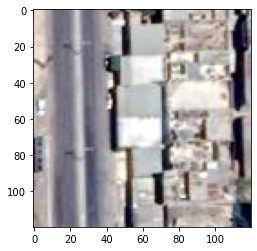

In [71]:
k=300
print(samples_pre_pathes[k])
img=samples[k][1].transpose(1,2,0).astype(np.uint8)
plt.imshow(img)

In [39]:
{city}_{str(i[0][0]).zfill(3)}{str(i[0][1]).zfill(3)}
str(samples[0][0][0]).zfill(3)

'001'

In [76]:
cos=[i.split('_')[-1].split('.')[0] for i in s]
cos=list(set(cos))
co=[i.split('_')[-1].split('.')[0] for i in samples_pre_pathes]
for i in cos:
    if i not in co:
        print(i)


In [75]:
s=torch.load('/ssd/hk/Syria_samples/split_havedamaged_size120_all_v2/cities/Homs/val.pth')
s=[i[0] for i in s]
ss=[]
for i in s:
    if '013062' in i:
        ss.append(i)
ss

[]

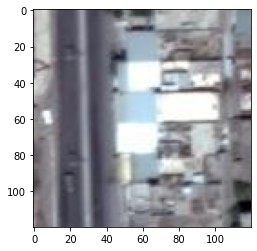

In [68]:
plt.imshow(imageio.imread('/ssd/hk/Syria_samples/samples_enhance_v2/pre/Homs_enhance-B-C-1_013062.png'))

# 创建samples_slip文件

In [160]:
size=120
for city in cities:
    print(city)
    mask_path=glob(f'/data2/Syria_img/{city}_areamask.tif')[0]
    mask=read_img(mask_path)['img']
    dammask_path=glob(f'/data2/Syria_img/{city}*dammask.pth*')
    dammask_path.sort()
    dammask_path_last=dammask_path[-1]
    dammask=torch.load(dammask_path_last)['mask'][0]
    print(dammask.shape)

    shape=mask.shape
    mask=np.pad(mask,((0,size-shape[0]%size),(0,size-shape[1]%size)),'constant',constant_values=0)
    shape=mask.shape
    mask=mask.reshape([int(shape[0]/size),-1,shape[1]])
    shape=mask.shape
    mask=mask.reshape([shape[0],shape[1],int(shape[2]/size),-1])
    mask=mask.transpose(0,2,1,3)
    print(mask.shape)
    shape=mask.shape

    sample_mask=np.zeros((shape[0],shape[1]))
    sample_p=[]
    sample_n=[]
    for x in range(shape[0]):
        for y in range(shape[1]):
            if dammask[x,y]>0:
                sample_mask[x,y]=1
            if (mask[x,y]==0).any() and (mask[x,y]==0).any():
                sample_mask[x,y]=-1
            if sample_mask[x,y]==1:
                sample_p.append([x,y])
            elif sample_mask[x,y]==0:
                sample_n.append([x,y])

    p_coord=[str(i[0]).zfill(3)+str(i[1]).zfill(3) for i in sample_p]
    n_coord=[str(i[0]).zfill(3)+str(i[1]).zfill(3) for i in sample_n]
    random.shuffle(p_coord)
    random.shuffle(n_coord)
    p_t_coord=p_coord[:int(len(p_coord)*0.7)]
    p_v_coord=p_coord[int(len(p_coord)*0.7):]
    n_t_coord=n_coord[:int(len(n_coord)*0.7)]
    n_v_coord=n_coord[int(len(n_coord)*0.7):]
    t=p_t_coord+n_t_coord
    v=p_v_coord+n_v_coord
    random.shuffle(t)
    random.shuffle(v)
    print(f't:{len(t)}   v:{len(v)}')
    torch.save(t,f'/ssd/hk/Syria_samples/coords_split/{city}_train.pth')
    torch.save(v,f'/ssd/hk/Syria_samples/coords_split/{city}_val.pth')
    # plt.figure(figsize=(15,15))
    # plt.imshow(sample_mask)
    # plt.colorbar()
    # plt.show()



Homs
(131, 152)
(131, 152, 120, 120)
t:6756   v:2896
Idlib
(62, 88)
(62, 88, 120, 120)
t:1790   v:768
Raqqa
(75, 207)
(75, 207, 120, 120)
t:5115   v:2193
Aleppo
(257, 472)
(257, 472, 120, 120)
t:29365   v:12586
Deir-ez-Zor
(103, 154)
(103, 154, 120, 120)
t:4571   v:1961
Hama
(163, 135)
(163, 135, 120, 120)
t:8325   v:3569


In [11]:
name

['Homs', 'Idlib', 'Raqqa', 'Aleppo', 'Deir-ez-Zor', 'Hama']

In [10]:
def match(string,input_list):
    new_data_list=[i for i in input_list if  re.match(string, i[0]) != None]
    return new_data_list
cities=['Idlib', 'Raqqa','Deir-ez-Zor', 'Hama']
city_sample=[]
for city in cities:
    t=torch.load(f'/ssd/hk/Syria_samples/coords_split/{city}_train.pth')
    v=torch.load(f'/ssd/hk/Syria_samples/coords_split/{city}_val.pth')
    print(city)
    for i in glob(f'/ssd/hk/Syria_samples/samples_v2/{city}*v2.pth'):
        city_sample+=torch.load(i)['info']
        
    for i in glob(f'/ssd/hk/Syria_samples/samples_enhance_v2/{city}*v2.pth'):
        city_sample+=torch.load(i)['info']


    for i in range(len(city_sample)):
        if len(city_sample[i][3])==2:
            if city_sample[i][3][0] is not None:
                city_sample[i][3]=city_sample[i][3][0]
            else:
                city_sample[i][3]=city_sample[i][3][1]
    city_pathes=[[i[0],'n'] if i[3][0]==0 else [i[0],'p'] for i in city_sample]
    random.shuffle(city_pathes)
    import re
    city_coord_sample={}
    city_coord_sample['train']={}
    city_coord_sample['val']={}
    print('match train')
    time.sleep(2)
    for i in tqdm(t):
        a=match(f'.*{i}.*',city_pathes)
        a.sort()
        city_coord_sample['train'][i]=a
    print('match val')
    time.sleep(2)
    for i in tqdm(v):
        a=match(f'.*{i}.*',city_pathes)
        a.sort()
        city_coord_sample['val'][i]=a
    torch.save(city_coord_sample,f'/ssd/hk/Syria_samples/split_havedamage_size120_all_v2/{city}.pth') 

Idlib
match train


100%|██████████| 1790/1790 [00:50<00:00, 35.37it/s]


match val


100%|██████████| 768/768 [00:21<00:00, 35.01it/s]


Raqqa
match train


100%|██████████| 5115/5115 [08:55<00:00,  9.55it/s]


match val


100%|██████████| 2193/2193 [03:49<00:00,  9.54it/s]


Deir-ez-Zor
match train


100%|██████████| 4571/4571 [14:08<00:00,  5.39it/s]


match val


100%|██████████| 1961/1961 [06:03<00:00,  5.39it/s]


Hama
match train


 95%|█████████▍| 7890/8325 [47:43<02:37,  2.76it/s]


KeyboardInterrupt: 

In [9]:
cities

['Homs', 'Idlib', 'Raqqa', 'Aleppo', 'Deir-ez-Zor', 'Hama']

In [124]:
if dammask_after is None:
        for x in range(shape[1]):
                for y in range(shape[2]):
                        
                        if (pre_patch[:,x,y]==999).any() and (post_patch[:,x,y]==999).any():
                                continue
                        else:
                                if dammask_before['mask'][0][x,y]>0:
                                        samples.append([[x,y],[[int(i[x,y]) for i in dammask_before['mask']],None],pre_patch[:,x,y],post_patch[:,x,y]])
                                        zz[x,y]=1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
fs=glob(f'/ssd/hk/Syria_samples/samples_enhance/*.pth')
for f_p in fs:
    f=torch.load(f_p)
    for i in range(len(f['info'])):
        info=f['info'][i]
        info[0]=info[0].replace('/data2/Syria_img/','/ssd/hk/').replace('/samples_enhance/','/samples_enhance_v2/')
        info[1]=info[1].replace('/data2/Syria_img/','/ssd/hk/').replace('/samples_enhance/','/samples_enhance_v2/')
        if not os.path.exists(info[0]):
            print(info[0])
        if not os.path.exists(info[1]):
            print(info[1])
    torch.save(f,f_p.replace('/samples_enhance/','/samples_enhance_v2/'))
    #     break
    # break

In [97]:
fs=glob(f'/ssd/hk/Syria_samples/samples_v2/*pth')
f=torch.load(fs[0])
f

{'readme': '4个字段\n 1:pre图像路径\n 2:post图像路径\n 3:图像坐标\n 4:损毁信息\n 损毁信息有5层\n 5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6',
 'info': [['/ssd/hk/Syria_samples/samples_v2/pre/Homs_B_0.png',
   '/ssd/hk/Syria_samples/samples_v2/post/Homs_B_0.png',
   [1, 121],
   [0, 0, 0, 0, 0]],
  ['/ssd/hk/Syria_samples/samples_v2/pre/Homs_B_1.png',
   '/ssd/hk/Syria_samples/samples_v2/post/Homs_B_1.png',
   [2, 116],
   [0, 2, 0, 6, 2]],
  ['/ssd/hk/Syria_samples/samples_v2/pre/Homs_B_2.png',
   '/ssd/hk/Syria_samples/samples_v2/post/Homs_B_2.png',
   [2, 117],
   [0, 0, 0, 0, 0]],
  ['/ssd/hk/Syria_samples/samples_v2/pre/Homs_B_3.png',
   '/ssd/hk/Syria_samples/samples_v2/post/Homs_B_3.png',
   [2, 118],
   [0, 0, 0, 0, 0]],
  ['/ssd/hk/Syria_samples/samples_v2/pre/Homs_B_4.png',
   '/ssd/hk/Syria_samples/samples_v2/post/Homs_B_4.png',
   [2, 119],
   [0, 0, 0, 0, 0]],
  ['/ssd/hk/Syria_samples/samples_v2/pre/Homs_B_5.png',
   '/ssd/hk/Syria_samples/samples_v2/post/Homs_

In [98]:
fs=glob(f'/ssd/hk/Syria_samples/samples_v2/*pth')
for f_p in fs:
    f=torch.load(f_p)
    print(f_p)
    for i in tqdm(range(len(f['info']))):

        coords=str(f['info'][i][2][0]).zfill(3)+str(f['info'][i][2][1]).zfill(3)
        replace='_'+f['info'][i][0].split('_')[-1]
        pre_path=f['info'][i][0].replace(replace,'_'+coords+'.png')
        post_path=f['info'][i][1].replace(replace,'_'+coords+'.png')
        os.rename(f['info'][i][0],pre_path)
        os.rename(f['info'][i][1],post_path)
        f['info'][i][0]=pre_path
        f['info'][i][1]=post_path
    torch.save(f,f_p.replace('.pth','_v2.pth'))

  3%|▎         | 245/9652 [00:00<00:03, 2446.16it/s]

/ssd/hk/Syria_samples/samples_v2/Homs_B_samples_info.pth


 28%|██▊       | 3274/11894 [00:00<00:00, 32735.58it/s]

/ssd/hk/Syria_samples/samples_v2/Hama_B_samples_info.pth


 65%|██████▍   | 7693/11894 [00:00<00:00, 38400.55it/s]

/ssd/hk/Syria_samples/samples_v2/Hama_C_samples_info.pth


  0%|          | 0/2558 [00:00<?, ?it/s]

/ssd/hk/Syria_samples/samples_v2/Deir-ez-Zor_D_samples_info.pth
/ssd/hk/Syria_samples/samples_v2/Idlib_D_samples_info.pth


  0%|          | 0/9652 [00:00<?, ?it/s]

/ssd/hk/Syria_samples/samples_v2/Idlib_B_samples_info.pth
/ssd/hk/Syria_samples/samples_v2/Homs_C_samples_info.pth


 19%|█▉        | 8076/42423 [00:00<00:00, 40173.62it/s]

/ssd/hk/Syria_samples/samples_v2/Aleppo_D_samples_info.pth


100%|██████████| 6532/6532 [00:00<00:00, 39665.26it/s]

/ssd/hk/Syria_samples/samples_v2/Deir-ez-Zor_C_samples_info.pth



 18%|█▊        | 7452/42423 [00:00<00:00, 38291.61it/s]

/ssd/hk/Syria_samples/samples_v2/Aleppo_B_samples_info.pth


  0%|          | 0/6532 [00:00<?, ?it/s]

/ssd/hk/Syria_samples/samples_v2/Idlib_E_samples_info.pth
/ssd/hk/Syria_samples/samples_v2/Idlib_C_samples_info.pth
/ssd/hk/Syria_samples/samples_v2/Deir-ez-Zor_B_samples_info.pth


100%|██████████| 7313/7313 [00:00<00:00, 41708.01it/s]

/ssd/hk/Syria_samples/samples_v2/Raqqa_D_samples_info.pth



100%|██████████| 6532/6532 [00:00<00:00, 35420.60it/s]

/ssd/hk/Syria_samples/samples_v2/Deir-ez-Zor_E_samples_info.pth



 19%|█▉        | 8055/42423 [00:00<00:00, 40156.29it/s]

/ssd/hk/Syria_samples/samples_v2/Aleppo_C_samples_info.pth


 18%|█▊        | 7834/42423 [00:00<00:00, 39141.12it/s]

/ssd/hk/Syria_samples/samples_v2/Aleppo_E_samples_info.pth


100%|██████████| 7313/7313 [00:00<00:00, 42428.12it/s]

/ssd/hk/Syria_samples/samples_v2/Raqqa_C_samples_info.pth


In [38]:
info[0].replace('/data2/','/ssd/hk/')

'/ssd/hk/Syria_img/Syria_samples/samples/pre/Homs_B_0.png'

In [39]:
os.path.exists('/ssd/hk/Syria_img/Syria_samples/samples/pre/')

False

In [27]:
#按照有无完全损毁划分
def get_val(v,index):
    if v[0] is None:
        return v[1][index]
    else:
        return v[0][index]
for city in cities:
    samples_list_files=glob(f'/ssd/hk/Syria_samples/samples_enhance/{city}*.pth')
    all_samples_list=[]
    print('load sample list files')
    time.sleep(2)
    for i in tqdm(samples_list_files):
        all_samples_list+=torch.load(i)['info']
    p_sample_list=[i[0] for i in all_samples_list if get_val(i[3],0)>0]
    n_sample_list=[i[0] for i in all_samples_list if get_val(i[3],0)==0]
    print('N:',len(n_sample_list))
    print('P:',len(p_sample_list))
    random.shuffle(n_sample_list)
    random.shuffle(p_sample_list)
    n_n=int(len(n_sample_list)*2/3)
    p_n=int(len(p_sample_list)*2/3)
    n_train_sample_list=[n_sample_list[i] for i in range(len(n_sample_list)) if i<n_n]
    n_val_sample_list=[n_sample_list[i] for i in range(len(n_sample_list)) if i>=n_n]
    p_train_sample_list=[p_sample_list[i] for i in range(len(p_sample_list)) if i<p_n]
    p_val_sample_list=[p_sample_list[i] for i in range(len(p_sample_list)) if i>=p_n]
    print(len(n_train_sample_list),len(n_val_sample_list))
    print(len(p_train_sample_list),len(p_val_sample_list))
    split_save_dir=f'/ssd/hk/Syria_samples/split_havedamaged_size120_enhance/cities/{city}/'
    torch.save(n_train_sample_list,split_save_dir+'train_n.pth')
    torch.save(n_val_sample_list,split_save_dir+'val_n.pth')
    torch.save(p_train_sample_list,split_save_dir+'train_p.pth')
    torch.save(p_val_sample_list,split_save_dir+'val_p.pth')

    train_sample=[[i,'n'] for i in n_train_sample_list]+[[i,'p'] for i in p_train_sample_list]
    val_sample=[[i,'n'] for i in n_val_sample_list]+[[i,'p'] for i in p_val_sample_list]
    split_save_dir=f'/ssd/hk/Syria_samples/split_havedamaged_size120_enhance/cities/{city}/'
    random.shuffle(train_sample)
    random.shuffle(val_sample)
    torch.save(train_sample,split_save_dir+'train.pth')
    torch.save(val_sample,split_save_dir+'val.pth')

load sample list files


100%|██████████| 8/8 [00:00<00:00, 20.64it/s]


N: 43928
P: 4378
29285 14643
2918 1460
load sample list files


100%|██████████| 11/11 [00:00<00:00, 93.16it/s]


N: 20040
P: 463
13360 6680
308 155
load sample list files


100%|██████████| 10/10 [00:00<00:00, 24.01it/s]


N: 43848
P: 2300
29232 14616
1533 767
load sample list files


100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


N: 494445
P: 14217
329630 164815
9478 4739


In [23]:
#正样本数量
files=glob('/data2/Syria_img/*dammask.pth.tar')
files.sort()
for f in files:
    print(f)
    masks=torch.load(f)
    print(masks['mask'][0].sum())

/data2/Syria_img/Aleppo_B_20130923_treated_size_120_dammask.pth.tar
202.0
/data2/Syria_img/Aleppo_C_20140523_treated_size_120_dammask.pth.tar
1450.0
/data2/Syria_img/Aleppo_D_20150426_treated_size_120_dammask.pth.tar
2538.0
/data2/Syria_img/Aleppo_E_20150918_treated_size_120_dammask.pth.tar
4773.0
/data2/Syria_img/Deir-ez-Zor_B_20131024_treated_size_120_dammask.pth.tar
285.0
/data2/Syria_img/Deir-ez-Zor_C_20140513_treated_size_120_dammask.pth.tar
452.0
/data2/Syria_img/Deir-ez-Zor_D_20150510_treated_size_120_dammask.pth.tar
538.0
/data2/Syria_img/Deir-ez-Zor_E_20160525_treated_size_120_dammask.pth.tar
802.0
/data2/Syria_img/Hama_B_20130926_treated_size_120_dammask.pth.tar
4585.0
/data2/Syria_img/Hama_C_20140305_treated_size_120_dammask.pth.tar
4670.0
/data2/Syria_img/Hama_D_20140305_treated_size_120_dammask.pth.tar
9459.0
/data2/Syria_img/Homs_B_20130926_treated_size_120_dammask.pth.tar
2524.0
/data2/Syria_img/Homs_C_20140421_treated_size_120_dammask.pth.tar
2950.0
/data2/Syria_img/Idl